In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils

from vcg_connectomics.utils.seg.aff_util import affinitize, seg_to_affgraph
from vcg_connectomics.utils.seg.seg_util import widen_border, mknhood3d
from vcg_connectomics.data.dataset import AffinityDataset, collate_fn
from vcg_connectomics.data.augmentation import *

from matplotlib import pyplot as plt

In [2]:
def show_imgs(imgs, label='aff'):
    plt.figure(figsize=(20,5))
    for i in range(1,5):
        plt.subplot('14%d' % (i))
        plt.imshow(imgs[i-1])
        plt.title(label+' '+str(i))
    plt.show()

In [3]:
# Load Data
data_path = '/n/coxfs01/zudilin/research/mitoNet/data/file/snemi/'
image_path = data_path + 'img/train-input_df_150.h5'
label_path = data_path + 'label/train-labels.h5'
image = np.array(h5py.File(image_path, 'r')['main'])
label = np.array(h5py.File(label_path, 'r')['main'])
print(image.shape, image.ndim, image.dtype)
print(label.shape, label.ndim, label.dtype)

(100, 1024, 1024) 3 uint8
(100, 1024, 1024) 3 uint16


In [4]:
model_io_size = (18, 160, 160)
# setup augmentor
augmentor = Compose([Rotate(p=1.0),
                        Rescale(p=0.5),
                        Flip(p=1.0),
                        Elastic(alpha=10.0, p=0.5),
                        Grayscale(p=0.75)], 
                        input_size = model_io_size)

print('data augmentation: ', augmentor is not None)

dataset = AffinityDataset(volume=[image / 255.0], label=[label], sample_input_size=augmentor.sample_size,
                          sample_label_size=augmentor.sample_size, augmentor=augmentor, mode = 'train')    
img_loader =  torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, collate_fn = collate_fn,
        num_workers=1, pin_memory=True)

Sample size required for the augmentor: [ 18 307 307]
data augmentation:  True


torch.Size([8, 1, 18, 160, 160]) torch.Size([8, 3, 18, 160, 160])


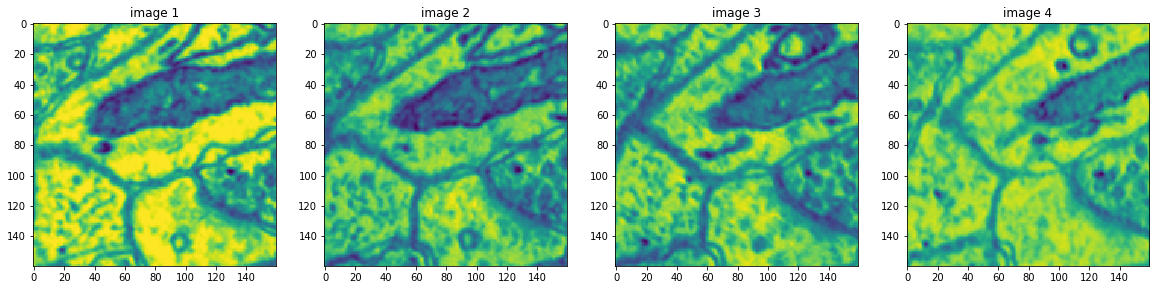

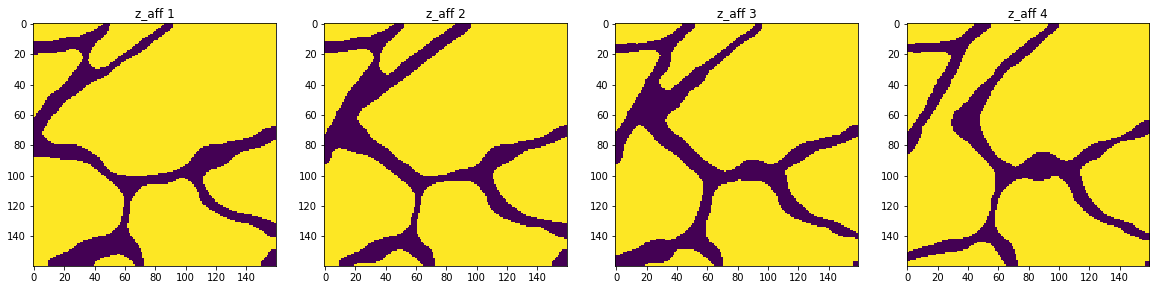

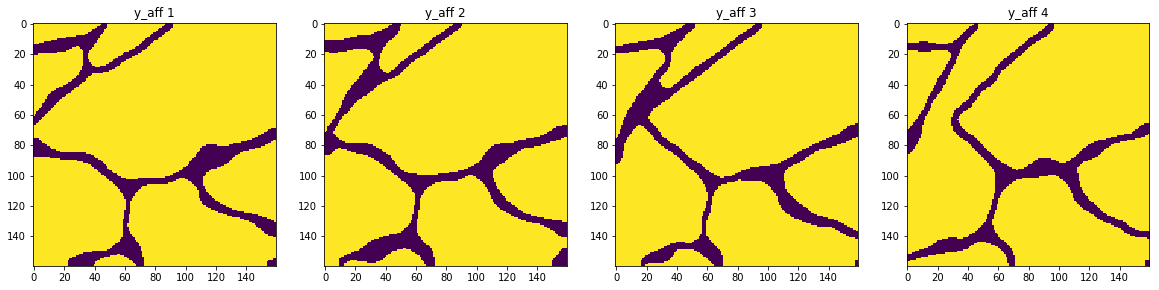

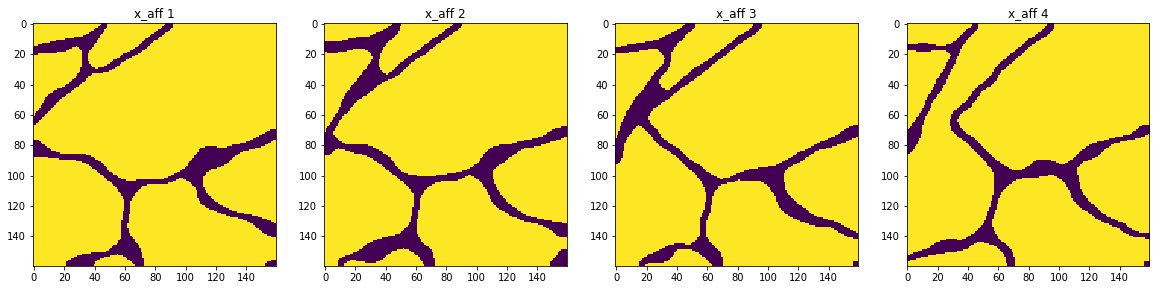

In [7]:
for iteration, (_, volume, label, class_weight, _) in enumerate(img_loader):
    if iteration==0:
        print(volume.size(), label.size())
        show_imgs(volume[0, 0, 8:12].detach().numpy(), 'image')
        show_imgs(label[0, 0, 8:12].detach().numpy(), 'z_aff')
        show_imgs(label[0, 1, 8:12].detach().numpy(), 'y_aff')
        show_imgs(label[0, 2, 8:12].detach().numpy(), 'x_aff')
        break